# Compare ATL10 freeboard profile with Sentinel-2 optical images

## 	&#x2B50; Objectives
- Query optical images in Google Earth Engine and download images overlapped with ICESat-2 track 
- Compare sea ice features from optical images and ICESat-2 ATL10 product

## &#x2705; Setting computing environment

We'll be using the following Python libraries in this notebook:

In [2]:
import glob, os
import requests
import numpy as np

from datetime import datetime
from datetime import timedelta

import h5py
import pandas as pd

import os

import warnings
warnings.filterwarnings('ignore')

import geopandas
import rasterio

import ee
import geemap

%matplotlib widget
import matplotlib.pyplot as plt

## &#x2705; Google Earth Engine Authentication and Initialization
Before you start Google Earth Engine (`ee` library), you need to authenticate your access with your own Google account. This authentication can be done by running `ee.Authenticate()`. Please go to the link and allow the access, and you will be able to get an verification code. Please copy and paste this verification code into the input field and hit enter.

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## &#x2705; Query Sentinel-2 images via Google Earth Engine using ATL10 track

In [4]:
# Read ATL10 track
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
filename = f"{tutorial_data}/processed_ATL10-02_20191113181045_07310501_005_02.h5"

# Create dataframe from the ATL10 file
with h5py.File(filename, 'r') as f:
    beam = 'gt2r'
    track = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                               'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                               'seg_x': f[beam]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][:],
                               'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                               'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:]
                              })

# Create Earth Engine feature collection with the ATL10 track
track_coord = list(zip([x for x in track.lon[::100]], [x for x in track.lat[::100]])) 
feature_track = ee.FeatureCollection(ee.Geometry.LineString(coords=track_coord, proj='EPSG:4326', geodesic=True)) 

# Define region of interest (ROI) using the ICESat-2 track feature collection
roi = feature_track.geometry()

In [5]:
# Read acquisition time of the ATL10 track from filename
time_atl = datetime.strptime(filename[-33:-19], "%Y%m%d%H%M%S")

In [6]:
# Start date (should be the ICESat-2 acquisition date)
t1 = time_atl.strftime("%Y-%m-%d")

# End date (1 day after the ICESat-2 acquistion date)
t2 = (datetime.strptime(t1, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

print(t1, t2)

2019-11-13 2019-11-14


In [7]:
# Query Sentinel-2 images using ATL10 file information
S2 = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(roi)\
.filterDate(t1, t2)\
.filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT', 20))\
.filter(ee.Filter.lt('NODATA_PIXEL_PERCENTAGE', 10))

In [8]:
num = S2.size().getInfo() # Number of available images
print(num)

3


In [9]:
# Image ID for all images
ids = [S2.toList(num).getInfo()[i]['id'] for i in range(0, num)] 
ids

['COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNU',
 'COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVP',
 'COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVQ']

In [10]:
time_diff = 3600*3 # Target time difference beteen ATL10 and Sentinel-2 < 3 hours

Map = geemap.Map()

for i in range(0, num):
    time_start = S2.toList(num).getInfo()[i]['properties']['system:time_start']
    time_s2 = datetime(1970, 1, 1) + timedelta(seconds = time_start/1000)   
    
    img_name = os.path.basename(ids[i])

    # Time difference between IS2 and S2 < defined time_diff
    if abs(time_atl-time_s2).seconds <= time_diff:
        img = ee.Image(ids[i]).select('B4')
        dim = img.getInfo()['bands'][0]['dimensions']
        if dim[0] > 10000 and dim[1] > 0:
            # # Download image into the local folder
            # geemap.download_ee_image(img, f"S2_{img_name}.tif", scale=50)
            Map.addLayer(img, {'min': 0, 'max': 10000}, img_name)
        else:
            print(f"SKIP {img_name}: Not a full image")
    else:
        print(f"SKIP {img_name}: Time difference > {time_diff/3600} hours with ICESat-2 track")

Map.centerObject(img, zoom = 7)
Map.addLayer(feature_track, {}, "IS2 track")
Map

Map(center=[-77.06741521860138, -166.80187469224302], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# !pip install geedim

## &#x2705; Comparison between ICESat-2 and Sentinel-2

Now we will compare the Sentinel-2 optical image we downloaded with the ICESat-2 ATL10 track.

In [13]:
# File name of the downloaded Sentinel-2 image
tutorial_data = "/home/jovyan/shared-public/ICESat-2-Hackweek/sea_ice"
img_name = f"{tutorial_data}/S2_20191113T183459_20191113T183501_T03CVQ.tif"

In [14]:
# Read Sentinel-2 image using raterio
img = rasterio.open(img_name)
array = img.read(1)
array[array < 0] = 0

height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# XY projected coordinate of the image
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)

img.close()

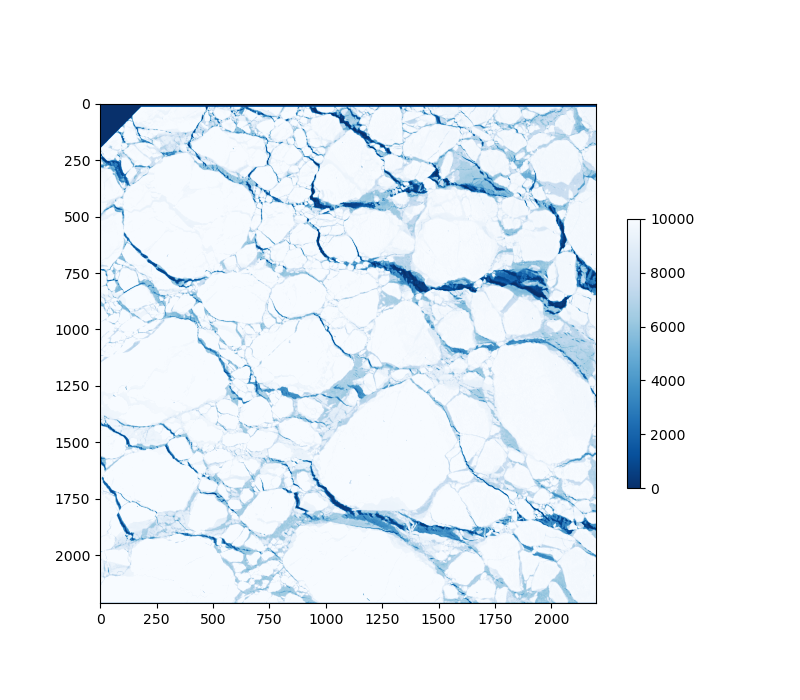

In [15]:
plt.figure(figsize = (8, 7))
plt.imshow(array, cmap = "Blues_r", vmin = 0, vmax = 10000)
plt.colorbar(shrink = 0.5)

Let's take a look at the ATL10 track data. We read the ATL10 h5 file as `pandas` dataframe. In order to assign the geographic coordinate information, we will convert this dataframe into `geopandas` geodataframe.

In [16]:
track

,lat,lon,seg_x,freeboard,type
0,-73.975637,-165.844054,2.832693e+07,0.080256,6
1,-73.975891,-165.844189,2.832696e+07,0.086212,6
2,-73.976071,-165.844283,2.832698e+07,0.092388,6
3,-73.976211,-165.844356,2.832700e+07,0.096061,1
4,-73.976379,-165.844443,2.832702e+07,0.096196,1
...,...,...,...,...,...
51063,-78.034301,-168.605746,2.878597e+07,0.152796,1
51064,-78.034363,-168.605802,2.878597e+07,0.154176,1
51065,-78.034440,-168.605870,2.878598e+07,0.151869,1
51066,-78.034497,-168.605921,2.878599e+07,0.154419,1


In [17]:
# Convert pandas dataframe into geopandas geodataframe
gdf = geopandas.GeoDataFrame(track, geometry=geopandas.points_from_xy(track.lon, track.lat))

# Assign crs information into geodatafraem
gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# Convert crs of the geodataframe into the crs of the Sentinel-2 image
gdf = gdf.to_crs(img.crs)

In [18]:
gdf

,lat,lon,seg_x,freeboard,type,geometry
0,-73.975637,-165.844054,2.832693e+07,0.080256,6,POINT (473993.423 1790495.816)
1,-73.975891,-165.844189,2.832696e+07,0.086212,6,POINT (473989.677 1790467.430)
2,-73.976071,-165.844283,2.832698e+07,0.092388,6,POINT (473987.050 1790447.305)
3,-73.976211,-165.844356,2.832700e+07,0.096061,1,POINT (473985.027 1790431.654)
4,-73.976379,-165.844443,2.832702e+07,0.096196,1,POINT (473982.612 1790412.817)
...,...,...,...,...,...,...
51063,-78.034301,-168.605746,2.878597e+07,0.152796,1,POINT (416597.305 1335234.132)
51064,-78.034363,-168.605802,2.878597e+07,0.154176,1,POINT (416596.446 1335227.123)
51065,-78.034440,-168.605870,2.878598e+07,0.151869,1,POINT (416595.394 1335218.517)
51066,-78.034497,-168.605921,2.878599e+07,0.154419,1,POINT (416594.610 1335212.104)


In [21]:
# Save coordinate information as independent columns (x, y)
gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

# Boundary of the image
x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

# Clip geodataframe fitting to the image extent
gdf = gdf[(gdf["x"]>=x_min) & (gdf["x"]<=x_max) & (gdf["y"]>=y_min) & (gdf["y"]<=y_max)].reset_index(drop=True)

idx = img.index(gdf["x"], gdf["y"])
gdf["pix_x"] = idx[1]
gdf["pix_y"] = idx[0]

In [22]:
gdf

,lat,lon,seg_x,freeboard,type,geometry,x,y,pix_x,pix_y
0,-76.561351,-167.431297,2.861903e+07,0.780125,1,POINT (436941.681 1500874.271),436941.680883,1.500874e+06,740,0
1,-76.561408,-167.431338,2.861903e+07,0.710218,1,POINT (436940.872 1500867.897),436940.872143,1.500868e+06,740,0
2,-76.561462,-167.431378,2.861904e+07,0.592511,1,POINT (436940.099 1500861.810),436940.098985,1.500862e+06,740,0
3,-76.561514,-167.431415,2.861904e+07,0.561554,1,POINT (436939.368 1500856.062),436939.368193,1.500856e+06,740,0
4,-76.561581,-167.431464,2.861905e+07,0.579661,1,POINT (436938.401 1500848.459),436938.400538,1.500848e+06,740,1
...,...,...,...,...,...,...,...,...,...,...
14608,-77.545559,-168.188758,2.873052e+07,0.300712,1,POINT (423266.985 1390259.877),423266.984926,1.390260e+06,467,2212
14609,-77.545639,-168.188823,2.873053e+07,0.513088,1,POINT (423265.900 1390250.831),423265.900493,1.390251e+06,467,2212
14610,-77.545691,-168.188866,2.873054e+07,0.486816,1,POINT (423265.192 1390244.950),423265.191837,1.390245e+06,467,2213
14611,-77.545753,-168.188917,2.873054e+07,0.527656,1,POINT (423264.346 1390237.969),423264.346224,1.390238e+06,467,2213


Draw overlapped optical image and ATL10 surface types (leads or not).

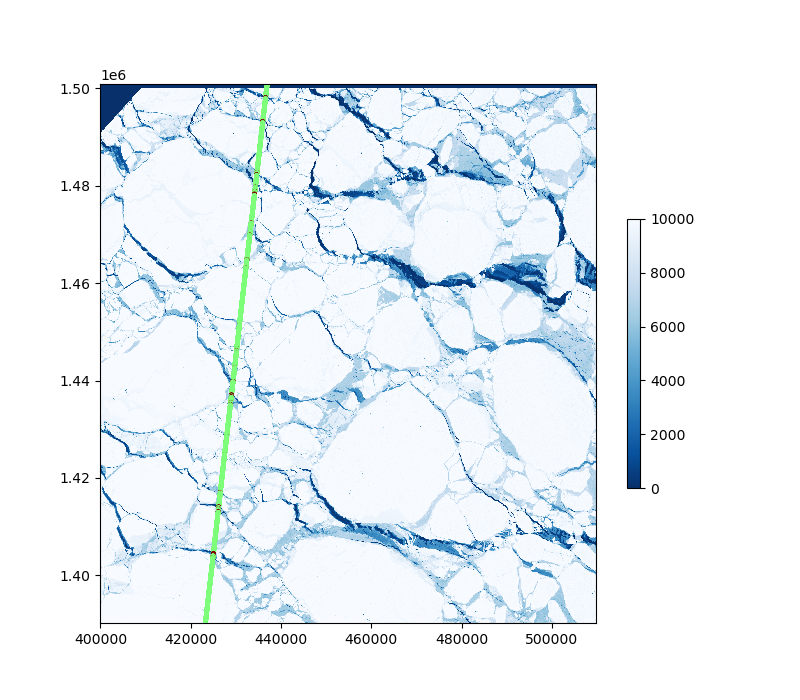

In [23]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = 0, vmax = 10000, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['type'], s = 5, vmin = 0, vmax = 2, cmap = "jet")

Draw optical image and ATL10 freeboard.

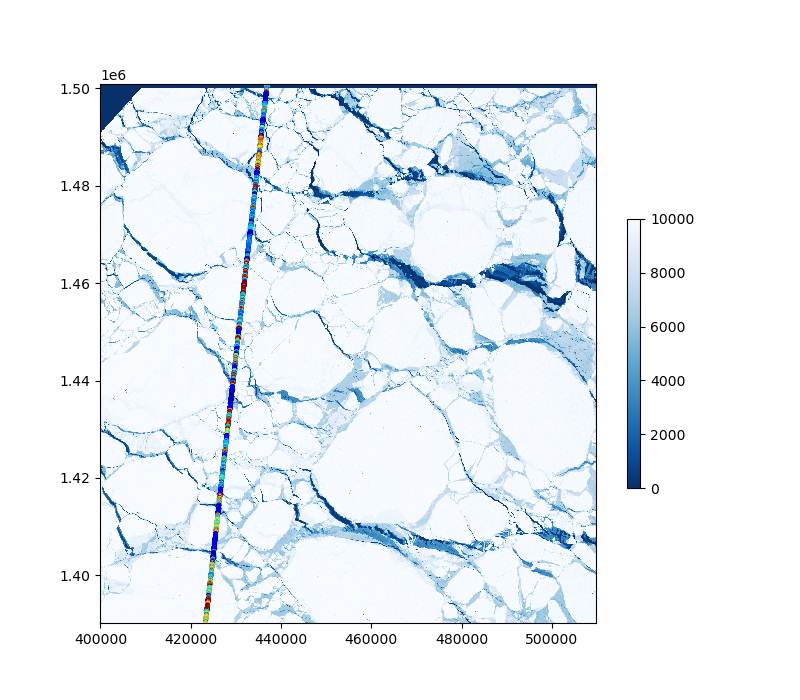

In [24]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = 0, vmax = 10000, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['freeboard'], s = 5, vmin = 0, vmax = 1, cmap = "jet")

## &#x2705; Floe statistics from ICESat-2 and Sentinel-2

Based on the overlapped Sentinel-2 optical image, we will calculate floe statistics. Since the optical image can be a good reference of lead detection, we compare the lead frequency and floe size distribution from the ATL10 data and Sentinel-2 optical image.

First, let's do a simple lead detection with the Sentinel-2 brigtness value. The dark area should be lead, and the white area should be sea ice floes.

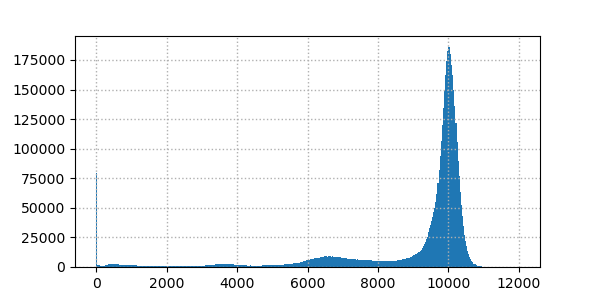

In [25]:
# Histogram of pixel value
plt.figure(figsize = (6,3))
plt.hist(array.flatten(), range = (0, 12000), bins = 400)
plt.grid(ls = ":", lw = 1);

Based on this histogram, which value is appropriate to separate sea ice floes and leads?

In [26]:
# Threshold value to separate sea ice floes and leads
th = 9000

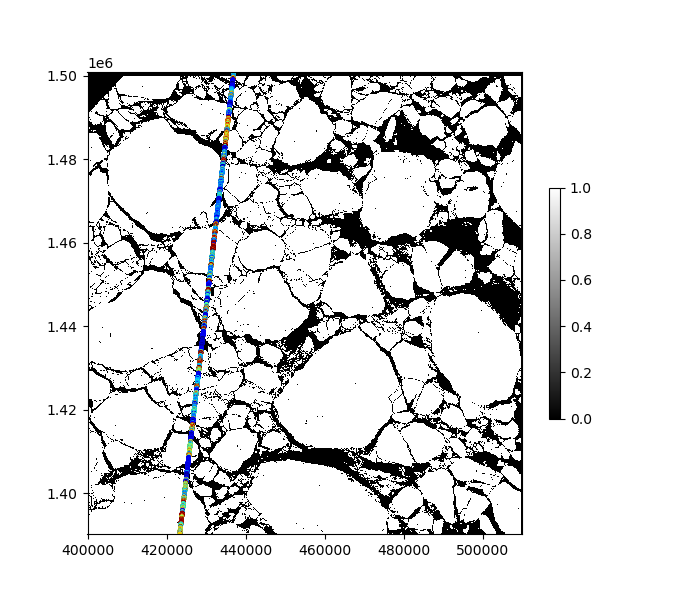

In [27]:
# Binary lead classification (0: lead, 1: sea ice floe)
classified = np.zeros(np.shape(array))
classified[array >= th] = 1

# Draw the lead classification image
plt.figure(figsize = (7,6))
plt.pcolormesh(xs, ys, classified, cmap = "gray")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['freeboard'], s = 5, vmin = 0, vmax = 1, cmap = "jet")
plt.show()

In [28]:
# Resample the raster value to the ICESat-2 track geodataframe
idx = img.index(gdf["x"], gdf["y"])
gdf["b4"] = array[idx[0], idx[1]]
gdf["lead_S2"] = classified[idx[0], idx[1]]

Now we will calculate the floe size statistics.

In [29]:
# Function to calculate sea ice floe length
def get_floe_length(freeboard, lead_mask, seg_dist):
    # INPUT:
    # freeboard: along-track freeboard measurement of ICESat-2 ATL10 track
    # lead_mask: along-track lead detection result (0: lead; 1: non-lead)
    # seg_dist: along-track distance of ICESat-2 ATL10 track (unit: meters)
    
    floe_length = np.array([]) # Floe length (unit: m)
    lead_length = np.array([]) # Floe length (unit: m)
    floe_fb = np.array([]) # np.zeros(len(ice_leads_msk)) # Making big enough array
    
    # Floe starting index
    ice_cnt_st = 0
    # Floe ending index
    ice_cnt_en = 0
    
    # Lead starting index
    lead_cnt_st = 0
    # Lead ending index
    lead_cnt_en = 0
    
    for i in range(1,len(freeboard)):
        if (lead_mask[i] == 1) and (lead_mask[i-1] == 0): # start floe & stop lead
            # Initialize floe
            ice_cnt_st = i
            ice_cnt_en = i
            
            # Complete lead
            lead_length = np.append(lead_length, abs(seg_dist[lead_cnt_en] - seg_dist[lead_cnt_st]))
                                    
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 1): # grow floe
            ice_cnt_en += 1
            
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 0): # grow lead
            lead_cnt_en += 1
            
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 1): # stop floe & start lead
            # Complete floe
            floe_length = np.append(floe_length, abs(seg_dist[ice_cnt_en] - seg_dist[ice_cnt_st]))
            floe_fb = np.append(floe_fb, np.mean(freeboard[ice_cnt_st:ice_cnt_en+1]))
            
            # Initialize lead
            lead_cnt_st = i
            lead_cnt_en = i
        
            
    # Removing spurious floes (< 50m, > 10 km, fb < 0.1)
    remove_idx = np.where((floe_length < 50) | (floe_length > 10000) | (floe_fb < 0.1))[0]  
    floe_fb = np.delete(floe_fb, remove_idx)
    floe_length = np.delete(floe_length,remove_idx)
    
    remove_idx = np.where(lead_length < 10)[0]
    lead_length = np.delete(lead_length,remove_idx)

    return floe_length, floe_fb, lead_length

In [30]:
# Freeboard lead mask (lead if freeboard < 0.15 m)
lead_mask = (gdf.freeboard >= 0.15).values # Lead should be 0

# Floe statistics from ATL10 (along-track)
floe_length1, floe_fb1, lead_length1 = get_floe_length(gdf.freeboard, lead_mask, gdf.seg_x)

In [31]:
# Overlapped Sentinel-2 lead mask (lead if pixel value < threshold)
lead_mask = gdf.lead_S2.values # Lead should be 0

# Floe statistics from Sentinel-2 (along-track)
floe_length2, floe_fb2, lead_length2 = get_floe_length(gdf.freeboard, lead_mask, gdf.seg_x)

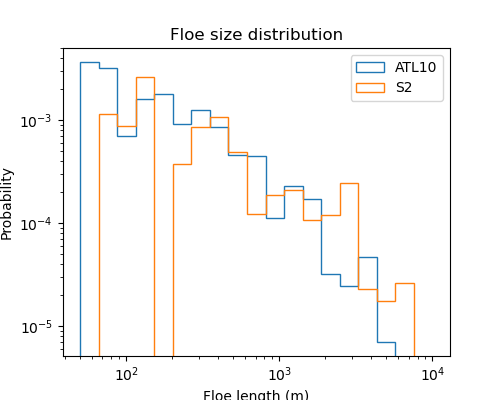

In [33]:
# FLoe length distribution

plt.figure(figsize = (5,4))

# Histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(50),np.log10(10000), 20)
plt.hist(floe_length1, bins=logbins, density = True, histtype = "step", label = "ATL10")
plt.hist(floe_length2, bins=logbins, density = True, histtype = "step", label = "S2")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Floe length (m)")
plt.ylabel("Probability")
plt.title("Floe size distribution")
plt.legend()
plt.show()


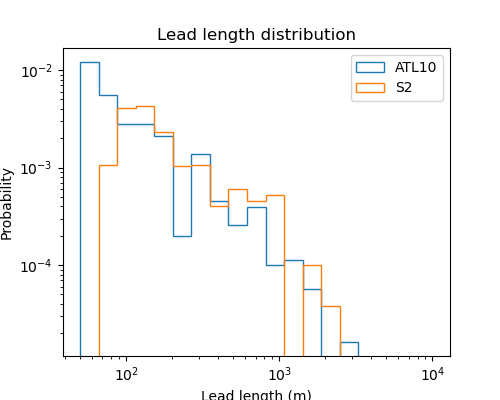

In [34]:
# Lead length distribution

plt.figure(figsize = (5,4))

# Histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(50), np.log10(10000), 20)
plt.hist(lead_length1, bins=logbins, density = True, histtype = "step", label = "ATL10")
plt.hist(lead_length2, bins=logbins, density = True, histtype = "step", label = "S2")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Lead length (m)")
plt.ylabel("Probability")
plt.title("Lead length distribution")
plt.legend()
plt.show()

**Credited by Younghyun Koo (kooala317@gmail.com)**